<a href="https://colab.research.google.com/github/ben854719/Trade-Transfer-Workflow-Optimizer/blob/main/ML_Stock_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from IPython import get_ipython
from IPython import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim

# Import the dataset for the client stock portfolio.
INDEX_CA_XTSE_GSPTSE_df = pd.read_csv('INDEX_CA_XTSE_GSPTSE.csv')

# Create a Scaler Object.
scaler =  StandardScaler()

# Numpy array for the dataset.
numerical_features = ['Date', 'Open', 'High', 'Low', 'Close']

for feature in numerical_features:
  if INDEX_CA_XTSE_GSPTSE_df[feature].dtype == 'object':
    le = LabelEncoder()
    INDEX_CA_XTSE_GSPTSE_df[feature] = le.fit_transform(INDEX_CA_XTSE_GSPTSE_df[feature])

# fit the scaler to the numerical features.
scaler.fit(INDEX_CA_XTSE_GSPTSE_df[numerical_features])
INDEX_CA_XTSE_GSPTSE_df[numerical_features] = scaler.transform(INDEX_CA_XTSE_GSPTSE_df[numerical_features])

# Create the tensor of input features and target variable.
X = torch.tensor(INDEX_CA_XTSE_GSPTSE_df[numerical_features].values, dtype=torch.float32)
Y = torch.tensor(INDEX_CA_XTSE_GSPTSE_df['Close'].values, dtype=torch.float32)

# train the model of the dataset.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# set a random seed.
torch.manual_seed(42)

# Scale target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))


# Convert y_train and y_test back to PyTorch tensors and reshape
y_train = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32)


# Check for NaN/Inf in input and target
x_train[torch.isnan(x_train)] = 0
x_train[torch.isinf(x_train)] = 0
y_train[torch.isnan(y_train)] = 0
y_train[torch.isinf(y_train)] = 0
x_test[torch.isnan(x_test)] = 0
x_test[torch.isinf(x_test)] = 0
y_test[torch.isnan(y_test)] = 0
y_test[torch.isinf(y_test)] = 0

# Define the model using nn.Sequential.
model = nn.Sequential(
    nn.Linear(X.shape[1], 32), # Use the number of input features from X
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1) # Output layer should have 1 output for regression
)

# MSE Loss Function + optimizer.
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200

epoch_format = 'Epoch[{0}/{1}], MSE.loss:{2:.4f}'

for epoch in range(num_epochs):
    predictions = model(x_train)
    MSE = loss_fn(predictions, y_train)

    # Check if loss is NaN and break.
    if torch.isnan(MSE):
        print(f"Loss is NaN at epoch {epoch + 1}. Stopping training.")
        break

    MSE.backward()

    # Check for NaN/Inf in model parameters and break.
    for name, param in model.named_parameters():
        if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
            display.display(f"NaN or Inf detected in gradients for parameter '{name}' at epoch {epoch + 1}.")
            break

    # Replace NaN/Inf in gradients with 0
    for name, param in model.named_parameters():
        if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
            param.grad.data.fill_(0)

    # Gradient Clipping.
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

    optimizer.step()
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        display.display(epoch_format.format(epoch + 1, num_epochs, MSE.item()))

    # Initialize weights after optimizer.step()
for m in model.modules():
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

'Epoch[10/200], MSE.loss:0.8650'

'Epoch[20/200], MSE.loss:0.6000'

'Epoch[30/200], MSE.loss:0.4033'

'Epoch[40/200], MSE.loss:0.2665'

'Epoch[50/200], MSE.loss:0.0857'

'Epoch[60/200], MSE.loss:0.1609'

'Epoch[70/200], MSE.loss:0.0742'

'Epoch[80/200], MSE.loss:0.0734'

'Epoch[90/200], MSE.loss:0.0809'

'Epoch[100/200], MSE.loss:0.0849'

'Epoch[110/200], MSE.loss:0.0659'

'Epoch[120/200], MSE.loss:0.0853'

'Epoch[130/200], MSE.loss:0.0619'

'Epoch[140/200], MSE.loss:0.0641'

'Epoch[150/200], MSE.loss:0.0449'

'Epoch[160/200], MSE.loss:0.0742'

'Epoch[170/200], MSE.loss:0.0583'

'Epoch[180/200], MSE.loss:0.0479'

'Epoch[190/200], MSE.loss:0.0253'

'Epoch[200/200], MSE.loss:0.0320'

In [4]:
# formula for torch save.
torch.save(model.state_dict(), 'model.pth')

In [42]:
# Load the model.
model = nn.Sequential(
    nn.Linear(x_test.shape[1], 32), # Use the number of input features from x_test
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, y_test.shape[1]) # Use the number of output features from y_test
)

# Load the state dictionary directly into the model
model.load_state_dict(torch.load('model.pth', weights_only=True))

# Set the model to evaluation mode.
model.eval()

#Replace NaN Valies in x_test with 0.
x_test[torch.isnan(x_test)] = 0

# Make predictions and calculate MSE.
with torch.no_grad():
    predictions = model(x_test)
    MSE = loss_fn(predictions, y_test)
    display.display(MSE)

tensor(1.9815)

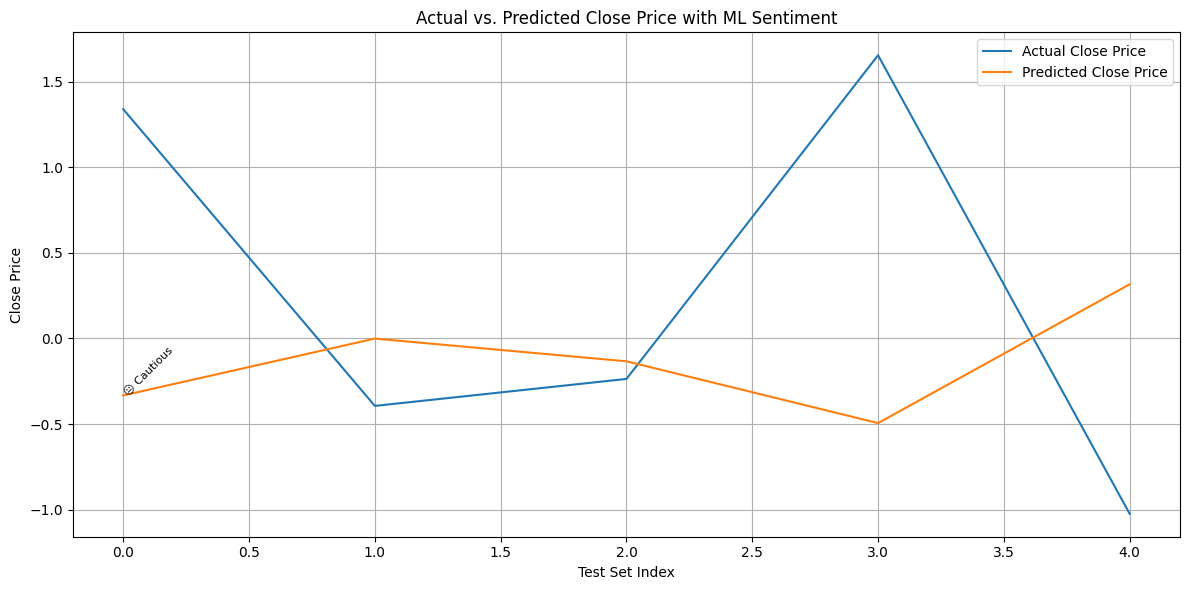

In [47]:
# Data Visualization

# === 1. Inverse transform predictions and actuals ===
y_test_actual = scaler_y.inverse_transform(y_test.cpu().numpy())
predictions_actual = scaler_y.inverse_transform(predictions.cpu().numpy())

# === 2. Define sentiment based on error ===
def get_sentiment(error):
    if error < 1:
        return "😌 Confident"
    elif error < 5:
        return "😐 Cautious"
    else:
        return "😲 Surprised"

# === 3. Create the plot ===
plt.figure(figsize=(12, 6))
sns.lineplot(x=np.arange(len(y_test_actual)), y=y_test_actual.flatten(), label='Actual Close Price')
sns.lineplot(x=np.arange(len(predictions_actual)), y=predictions_actual.flatten(), label='Predicted Close Price')
plt.title('Actual vs. Predicted Close Price with ML Sentiment')
plt.xlabel('Test Set Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

# === 4. Annotate sentiment every 20 points ===
for i in range(0, len(y_test_actual), 20):
    error = abs(y_test_actual[i] - predictions_actual[i])
    sentiment = get_sentiment(error)
    plt.text(i, predictions_actual[i], sentiment, fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
Explanation:

This graph compares the actual and predicted close prices over time, with emotional annotations showing where the model felt confident, cautious, or surprised based on its prediction accuracy.